### Character level name classification.

In this notebook we are going to learn how to classify names. We will be following [this](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) to understand how we can perform this task. First we must download the [dataset](https://download.pytorch.org/tutorial/data.zip) which I've already downloaded and uploaded it on my google drive. Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

### Imports

In [1]:
from __future__ import unicode_literals
import string, unicodedata, os, time, random, math

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import  Dataset, DataLoader

import matplotlib.pyplot as plt
from prettytable import PrettyTable

import numpy as np
from torchtext.legacy import data, datasets
import matplotlib.ticker as ticker

torch.__version__

'1.9.0+cu102'

### Seeds


In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Mounting the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = '/content/drive/My Drive/NLP Data/seq2seq/data/names'
os.path.exists(file_path)

True

In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters

57

We need a function that turns ``Unicode`` characters to `ASCII` characters. Basically the function will convert text from this kind of domain `Ślusàrski` to `Slusarski`

In [7]:
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

Slusarski


Builing the category line dictionary of list of names per language.

In [8]:
def readLines(filename):
  lines = open(filename, encoding="utf-8").read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

In [9]:
categories = []
category_names = {}

for file in os.listdir(file_path):
  category = file.split('.')[0]
  categories.append(category)
  category_names[category] = readLines(os.path.join(file_path, file))
len(categories)

18

In [10]:
category_names.get("French")[:5]

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']

### Converting names into tensors

To represent a single letter we are going to make use of `one_hot_vector` where each letter will be representet with a vector of `[1, n_letters]`. Where the index of the current letter will be the only 1 in the vector and others will be only zeros.

In [11]:
def letterToIndex(letter):
  return all_letters.find(letter)

In [12]:
def letterToTensor(letter):
  return torch.from_numpy(
      np.eye(n_letters, dtype="float32")[letterToIndex(letter)].reshape(1, -1)
  )
print(letterToTensor(';'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0.]])


In [13]:
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for i, letter in enumerate(line):
    tensor[i][0][letterToIndex(letter)] = 1
  return tensor

print(lineToTensor('Jones').size())
print(lineToTensor('Jones'))

torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

### Model definition.

We are going to create our `RNN` layer or module from scratch. The achitecture looks as follows:

![img](https://i.imgur.com/Z2xbySO.png)

In [24]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
  
  def forward(self, input, hidden):
    hidden = hidden.to(device)
    input = input.to(device)
    combined = torch.cat((input, hidden), 1)
    
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    return output, hidden
  def initHidden(self):
    return torch.rand(size=(1, self.hidden_size))

In [25]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, len(categories)).to(device)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [26]:
input = letterToTensor('A').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn(input, hidden)

In [27]:
input = lineToTensor('Albert').to(device)
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[ 0.0085,  0.0400,  0.0183,  0.0599,  0.0601,  0.0283, -0.1087,  0.0567,
         -0.0821, -0.0028, -0.0840, -0.0157, -0.0156,  0.0181, -0.0343,  0.0729,
         -0.0339, -0.0503]], device='cuda:0', grad_fn=<AddmmBackward>)


### Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category.





In [28]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return categories[category_i], category_i
print(categoryFromOutput(output))

('Japanese', 15)


In [29]:
def randomChoice(l):
   return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(categories)
  line = randomChoice(category_names[category])
  category_tensor = torch.tensor([categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)


category = Czech / line = Till
category = Scottish / line = Smith
category = French / line = Porcher
category = Vietnamese / line = Kim
category = Russian / line = Halepsky
category = Vietnamese / line = Ngo
category = English / line = Howell
category = Spanish / line = Oleastro
category = Italian / line = Selvaggio
category = Scottish / line = Thomson


### Loss

In [30]:
criterion = nn.NLLLoss().to(device)

In [31]:
optimimizer = torch.optim.Adam(rnn.parameters())

### Training loop
* Create input and target tensors
* Create a random initial hidden state
* Read each letter in and
* Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [32]:
def train(category_tensor, line_tensor, optimimizer, model):
  model.train()
  category_tensor = category_tensor.to(device)
  line_tensor = line_tensor.to(device)

  hidden = model.initHidden()
  optimimizer.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = model(line_tensor[i], hidden)
  loss = criterion(output, category_tensor)
  optimimizer.step()
  return output, loss.item()

In [33]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)
start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor, optimimizer, rnn)

  current_loss += loss
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

  # Add current loss avg to list of losses
  if iter % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      current_loss = 0


5000 5% (0m 6s) -0.0674 Ruhlyadko / Japanese ✗ (Russian)
10000 10% (0m 13s) 0.1001 Zabek / English ✗ (Polish)
15000 15% (0m 20s) 0.1224 Zientek / English ✗ (Polish)
20000 20% (0m 27s) -0.0163 Kolen / French ✗ (Dutch)
25000 25% (0m 34s) 0.1449 Meisner / Irish ✗ (German)
30000 30% (0m 41s) 0.1584 Ritter / Irish ✗ (German)
35000 35% (0m 47s) 0.0666 Toset / Italian ✗ (Spanish)
40000 40% (0m 54s) -0.0369 Qian / Japanese ✗ (Chinese)
45000 45% (1m 1s) 0.1194 Heidrich / Japanese ✗ (German)
50000 50% (1m 8s) 0.0060 Ron / Japanese ✗ (Korean)
55000 55% (1m 14s) -0.0767 Saigo / Japanese ✓
60000 60% (1m 21s) -0.0409 Jon / Russian ✗ (Korean)
65000 65% (1m 28s) 0.0967 Krauss / English ✗ (German)
70000 70% (1m 35s) 0.0364 An / Italian ✗ (Vietnamese)
75000 75% (1m 41s) 0.0109 Pantelas / English ✗ (Greek)
80000 80% (1m 48s) -0.1993 Roy / French ✓
85000 85% (1m 55s) -0.1051 Murkami / English ✗ (Japanese)
90000 90% (2m 2s) -0.0311 Youj / English ✗ (Korean)
95000 95% (2m 8s) -0.0140 Karameros / English ✗ (

### Plotting results

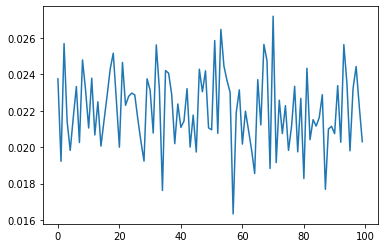

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

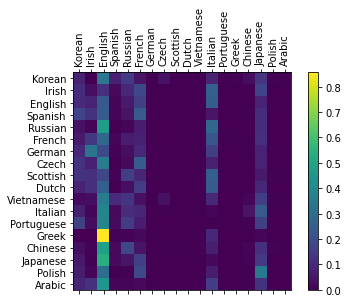

In [39]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories), len(categories))
n_confusion = 10000
# Just return an output given a line
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = categories.index(category)
  confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories)):
  confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories, rotation=90)
ax.set_yticklabels([''] + categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_galler

### User input

In [42]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))

    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, categories[category_index]))
      predictions.append([value, categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.10) Japanese
(0.09) Italian
(0.09) French

> Jackson
(0.13) Italian
(0.13) Russian
(0.07) Japanese

> Satoshi
(0.17) English
(0.10) Japanese
(0.08) Spanish


### Conclusion

We have learnt a lot in this notebook.

### Todos
* Try with a different dataset of line -> category, for example:
* Any word -> language
* First name -> gender
* Character name -> writer
* Page title -> blog or subreddit

_Get better results with a bigger and/or better shaped network_
* Add more linear layers
* Try the `nn.LSTM` and `nn.GRU` layers
* Combine multiple of these RNNs as a higher level network

### Ref:

[this tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

